In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
users = pd.read_csv('/content/drive/MyDrive/ml-1m/users.dat', sep='::',engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip'])

ratings = pd.read_csv('/content/drive/MyDrive/ml-1m/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])

movies = pd.read_csv('/content/drive/MyDrive/ml-1m/movies.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False)

In [4]:
movies['movieid_norm'] = np.arange(len(movies.movieid))
ratings = ratings.merge(movies, how='left', left_on='movieid', right_on='movieid')

In [5]:
# ratings['rating_date'] = ratings.timestamp.apply(
#     lambda x: datetime.fromtimestamp(x)
# )

In [6]:
# ratings.userid = ratings.userid - 1

In [7]:
mintime = min(ratings.timestamp)

In [8]:
maxtime = max(ratings.timestamp)

In [9]:
movies_list = [movie for movie in ratings.movieid.unique() if len(ratings[ratings.movieid == movie].userid.unique()) >= 10]

In [10]:
len(movies_list)

3260

In [11]:
ratings['choose'] = ratings.movieid.apply(
    lambda x: 1 if x in movies_list else 0
)

In [12]:
cnt = 0
for movie in ratings.movieid.unique():
    if movie in movies_list:
        ratings.loc[ratings.movieid == movie, 'movieid_norm'] = cnt
        cnt += 1
    else:
        ratings.loc[ratings.movieid == movie, 'movieid_norm'] = -1


In [13]:
# users_list = np.array(ratings.userid.unique())
users_list = [user for user in ratings.userid.unique() if len(ratings[ratings.userid == user].movieid) >= 20]
ui = {}

with open('user_item.txt', 'w') as f:
  for user in tqdm(users_list):
    movie_list = ratings[(ratings.userid == user) & (ratings.movieid_norm > 0) & (ratings.rating >= 3)].movieid_norm.unique()
    ui[user] = movie_list
    for movie in movie_list:
      f.write(f'{user}\t{movie}\n')

100%|██████████| 6040/6040 [00:40<00:00, 147.35it/s]


In [14]:
len(users_list)

6040

In [15]:
ratings['timestamp_norm'] = ratings.timestamp.apply(
    lambda x: x - mintime
)

In [16]:
month_time = 30 * 24 * 60 * 60
week_time = 7 * 24 * 60 * 60
three_day = 3 * 24 * 60 * 60
one_day = 24 * 60 * 60
h_hour = 8 * 60 * 60
a_hour = 60 * 60

In [17]:
ratings['month'] = ratings.timestamp_norm.apply(
    lambda x: int(x/month_time) + 1
)

In [18]:
ratings['week'] = ratings.timestamp_norm.apply(
    lambda x: int(x/week_time) + 1
)

In [19]:
ratings['three_days'] = ratings.timestamp_norm.apply(
    lambda x: int(x/three_day) + 1
)

In [20]:
ratings['one_day'] = ratings.timestamp_norm.apply(
    lambda x: int(x/one_day) + 1
)

In [21]:
ratings['h_hour'] = ratings.timestamp_norm.apply(
    lambda x: int(x/h_hour) + 1
)

In [22]:
ratings['a_hour'] = ratings.timestamp_norm.apply(
    lambda x: int(x/a_hour) + 1
)

In [23]:
import random
bundle_dict = {}
user_bundle = {user: [] for user in users_list}
random.seed(2024)

with open('bundle_item.txt', 'w') as f2, open('user_bundle_train.txt', 'w') as f3, open('user_bundle_tune.txt', 'w') as f4, open('user_bundle_test.txt', 'w') as f5:
  for user in tqdm(users_list):
    bundles = []
    for one_day in ratings[ratings.userid == user].one_day.unique():
      bundle = ratings[(ratings.userid == user) & (ratings.one_day == one_day) & (ratings.movieid_norm > 0) & (ratings.rating >= 3)].movieid_norm.unique()
      bundle.sort()
      bundle = tuple(bundle)

      if len(bundle) > 2:
        if bundles not in user_bundle[user]:
          user_bundle[user].append(bundles)

        if bundle not in bundle_dict:
          bundle_dict[bundle] = len(bundle_dict)
          for item in bundle:
            f2.write(f'{bundle_dict[bundle]}\t{item}\n')
        bundles.append(bundle)

    random.shuffle(bundles)
    if len(bundles) >= 1:
      for bundle in bundles[:int(0.6*len(bundles))]:
        f3.write(f'{user}\t{bundle_dict[bundle]}\n')

      for bundle in bundles[int(0.6*len(bundles)):int(0.8*len(bundles))]:
        f4.write(f'{user}\t{bundle_dict[bundle]}\n')

      for bundle in bundles[int(0.8*len(bundles)):]:
        f5.write(f'{user}\t{bundle_dict[bundle]}\n')

100%|██████████| 6040/6040 [03:31<00:00, 28.51it/s]


In [24]:
len(bundle_dict)

13807

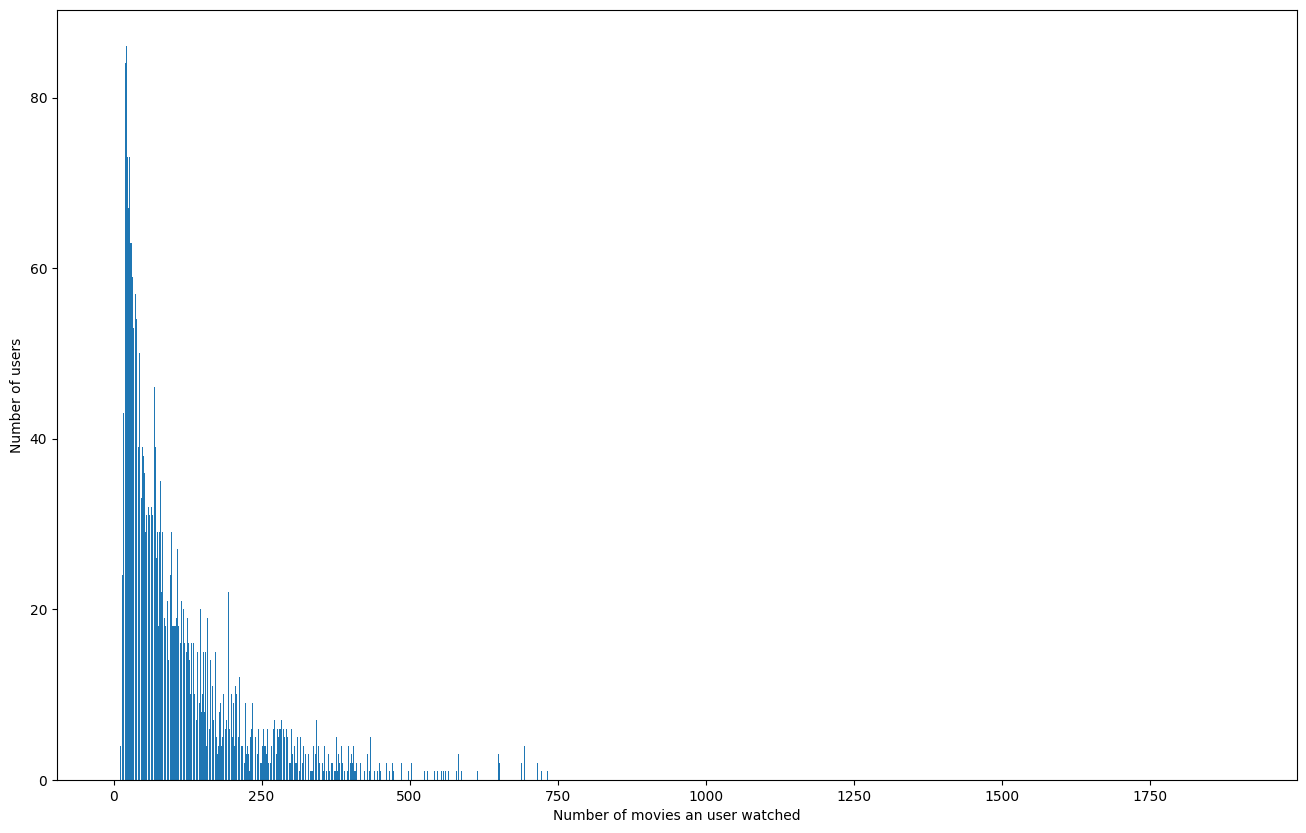

In [25]:
ui_dict = {}
for user, item in ui.items():
  if len(item) not in ui_dict:
    ui_dict[len(item)] = 0
  else:
    ui_dict[len(item)] += 1

plt.figure(figsize=(16, 10))
plt.bar(ui_dict.keys(), ui_dict.values())
plt.xlabel('Number of movies an user watched')
plt.ylabel('Number of users')
plt.show()

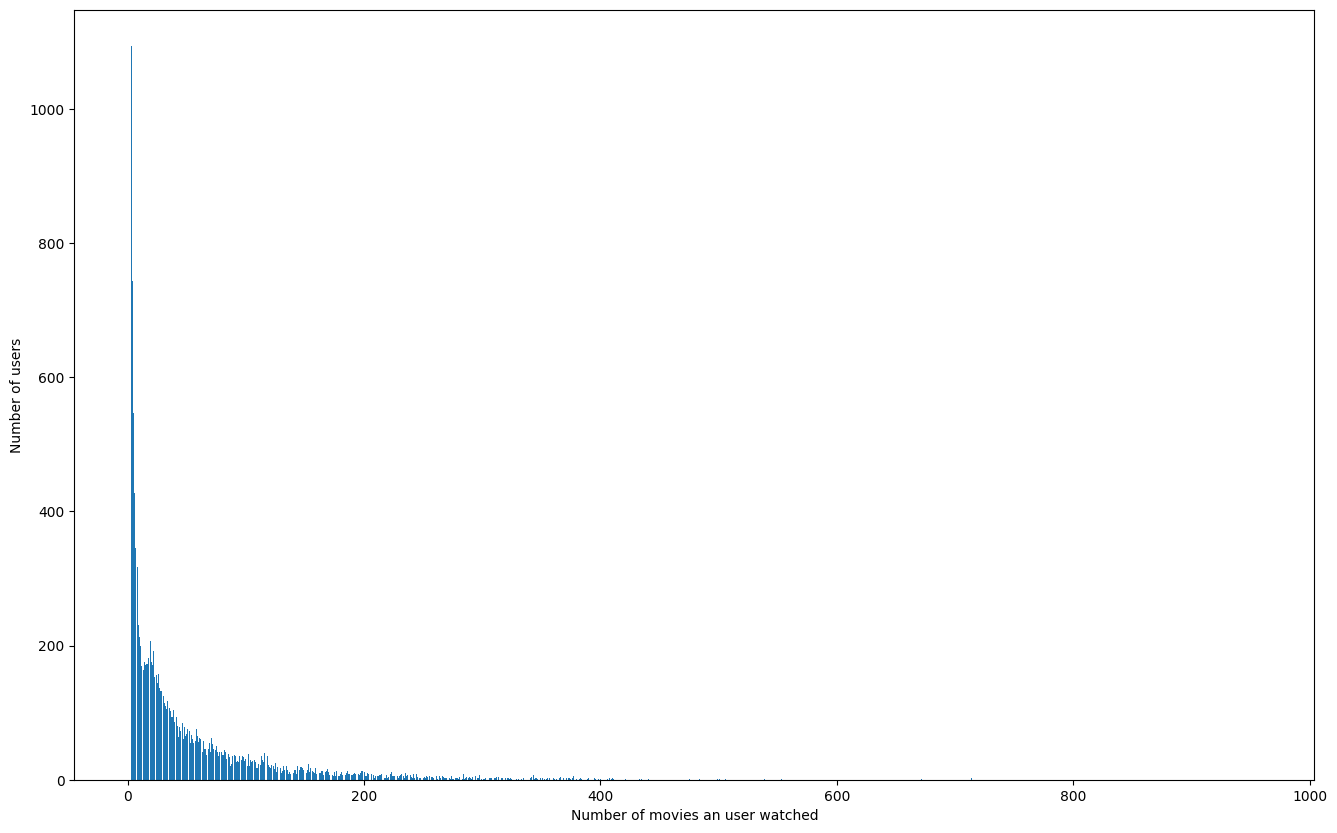

In [26]:
bi_dict = {}

for b, idx in bundle_dict.items():
  if len(b) not in bi_dict:
    bi_dict[len(b)] = 0
  else:
    bi_dict[len(b)] += 1

plt.figure(figsize=(16, 10))
plt.bar(bi_dict.keys(), bi_dict.values())
plt.xlabel('Number of movies an user watched')
plt.ylabel('Number of users')
plt.show()

In [31]:
ub_dict = {}
for b, idx in bundle_dict.items():
  for user in users_list:
    if b in user_bundle[user]:
      ub_dict[bundle_dict[b]] += 1
    else:
      ub_dict[bundle_dict[b]] = 1

AttributeError: 'dict' object has no attribute 'item'

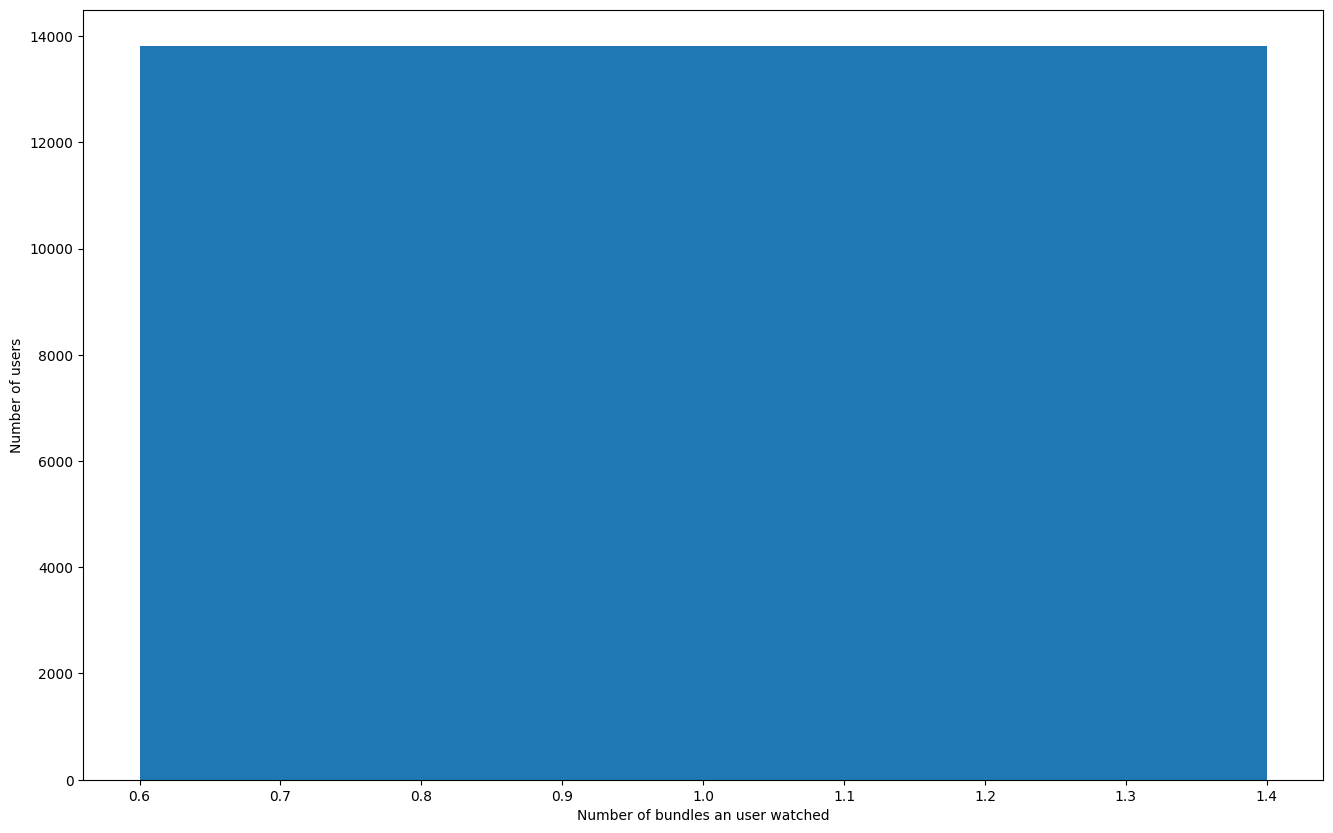

In [35]:
bu_dict = {freq: 0 for b, freq in ub_dict.items()}
for b, freq in ub_dict.items():
  bu_dict[freq] += 1

plt.figure(figsize=(16, 10))
plt.bar(bu_dict.keys(), bu_dict.values())
plt.xlabel('Number of bundles an user watched')
plt.ylabel('Number of users')
plt.show()

In [ ]:
# norm = movies.movieid_norm.unique()
# with open('/content/drive/MyDrive/ml-1m/movieid_lookup.txt', 'w') as f:
#   for id in tqdm(norm):
#     f.write(f'{id}\t{movies[movies.movieid_norm==id].movieid}\n')


100%|██████████| 3883/3883 [00:02<00:00, 1456.79it/s]
